In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import math
from src.encoders_decoders import *
from src.losses import *
from torch.utils.data import DataLoader
import random
import importlib

In [2]:
# set device
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

In [18]:
#Architecture parameters and distributions of stimuli
N = 10

#p_x = torch.distributions.uniform.Uniform(0,10)
p_x = torch.distributions.exponential.Exponential(0.5)

#Training parameters
N_EPOCHS = 1000
N_SAMPLES = 30000
#lr = 1e-2
BATCH_SIZE = 500

#Generate samples
x_samples = p_x.sample((N_SAMPLES,))[:,None]
x_sorted,indices = x_samples.sort(dim=0)
x_min,x_max = x_sorted[0,:].item(),x_sorted[-1,:].item()
x_data = torch.utils.data.DataLoader(x_samples,batch_size=BATCH_SIZE, shuffle = True)
x_fine = torch.linspace(x_min,x_max,1000)[None,:].transpose(0,1)

#ATTEMPT
class CategoricalEncoder1(torch.nn.Module):
    #It returns for each stimulus x a vector of (unnormalized) probabilities 
    # (i.e.logits) of activation for each neuron, which is a quadratic function
    # of x. 
    def __init__(self,c0,sigma0,q0):
        super().__init__()
        self.a,self.b,self.c = initialize_categorical_params(c0,sigma0,q0)
    def forward(self,x):
        # x has shape [bsize_size, xdim], a,b,c has shape [xdim, N]
        p_tilde = (x**2)@(self.a) + x@(self.b) + self.c
        return p_tilde
    def sample(self,x,nsamples):
        _,N = self.a.shape
        p_r_x = F.softmax(self.forward(x),dim=1)
        r_cat = torch.distributions.categorical.Categorical(p_r_x).sample((nsamples,))
        r = F.one_hot(r_cat,N).to(dtype=torch.float32)
        return r


decoder = MoGDecoder(N,x_min,x_max,x_sorted)
encoder = CategoricalEncoder(decoder.mus.transpose(0,1),torch.exp(decoder.log_sigmas).transpose(0,1),decoder.qs.transpose(0,1))

enc = CategoricalEncoder1(decoder.mus.transpose(0,1),torch.exp(decoder.log_sigmas).transpose(0,1),decoder.qs.transpose(0,1))


#Define optimizer and parameters to iterate on
params = list(decoder.parameters()) + list(encoder.parameters())
optimizer = torch.optim.SGD([
                {'params': params[0:2]},
                {'params': params[2],'lr':1e-2}
                ],0.01)
#optimizer=torch.optim.Adam(params, lr=1e-2)


#The mus are now initialized using a KMEANS algorithm 

In [22]:
x_fine.shape
r = enc.sample(x_fine,1)
r.shape

torch.Size([1, 1000, 10])

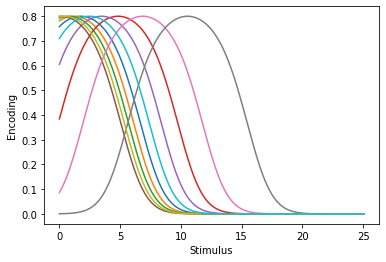

In [4]:
#encoding before training
x_fine = torch.linspace(x_min,x_max,1000)[:,None]
plt.xlabel("Stimulus")
plt.ylabel("Encoding")
plt.plot(x_fine,torch.sigmoid(encoder(x_fine)).detach())

In [5]:
torch.sort(decoder.mus, dim = 0)

torch.return_types.sort(
values=tensor([[ 0.1391],
        [ 0.4383],
        [ 0.7772],
        [ 1.2068],
        [ 1.7606],
        [ 2.5164],
        [ 3.4927],
        [ 4.8920],
        [ 7.0358],
        [11.1604]], grad_fn=<SortBackward>),
indices=tensor([[5],
        [8],
        [2],
        [1],
        [0],
        [9],
        [4],
        [3],
        [6],
        [7]]))

In [5]:
#training 
total_batch = int(N_SAMPLES/BATCH_SIZE)
print(total_batch)



60


In [7]:
#Loss and mse computed as the average over the mini batches for each epoch
avg_loss = []
avg_mse = []
loss_tot_batch = []
loss_tot_epoch = []


for epoch in range(N_EPOCHS):
    avg_loss_item=0
    avg_mse_item=0
    

    for i in range(total_batch):
        batch_start, batch_end = i*BATCH_SIZE, i*BATCH_SIZE + BATCH_SIZE
        x_batch= x_samples[batch_start:batch_end]
        loss = distortion_cat(x_batch, encoder, decoder) + rate_cat(x_batch, encoder, decoder)
        loss1=distortion_cat(x_samples, encoder, decoder) + rate_cat(x_samples, encoder, decoder)

        mse = MSE_cat(x_batch, decoder, encoder)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss1 = loss1.item()
        loss_tot_batch.append(running_loss1)

        avg_loss_item += loss.item()/total_batch
        avg_mse_item += mse.item()/total_batch

    running_loss2 = loss1.item()
    loss_tot_epoch.append(running_loss2)
    avg_loss.append(avg_loss_item)
    avg_mse.append(avg_mse_item)
    
    




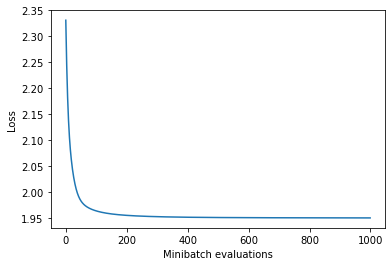

In [11]:
# Avarage of the loss on batches 
plt.xlabel("Minibatch evaluations")
plt.ylabel("Loss")
plt.plot(avg_loss)

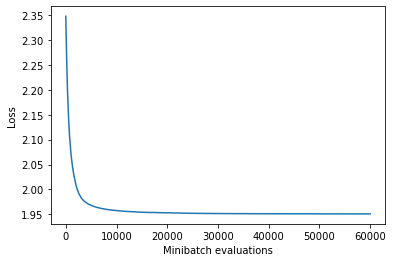

In [10]:
# LOSS on the whole data set evaluated at every batch step
plt.xlabel("Minibatch evaluations")
plt.ylabel("Loss")
plt.plot(loss_tot_batch)

In [ ]:
# LOSS on the whole data set evaluated at each epoch
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(loss_tot_epoch)

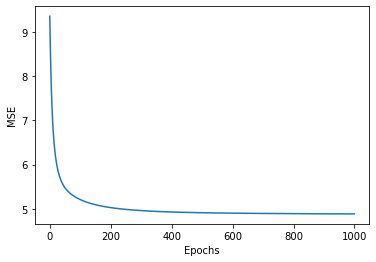

In [9]:
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.plot(avg_mse)

<ipython-input-10-fe7deec8310e>:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  plt.plot(x_fine,F.softmax(encoder(x_fine)[:,:]))


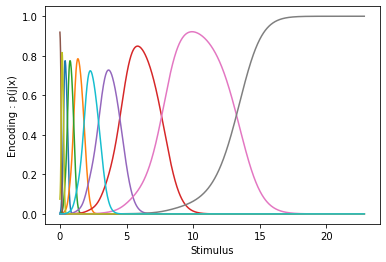

In [10]:
#Reproducing Woodford's plots: ENCODING
x_fine = torch.linspace(x_min,x_max,1000)[:,None]
with torch.no_grad():
    plt.xlabel("Stimulus")
    plt.ylabel("Encoding : p(j|x)")
    plt.plot(x_fine,F.softmax(encoder(x_fine)[:,:])) 

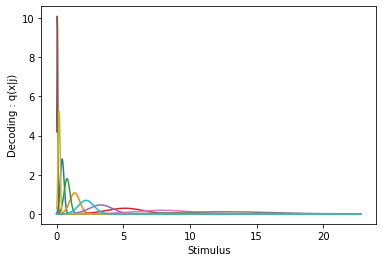

In [11]:
#DECODING

gaussian = torch.distributions.normal.Normal(decoder.mus, torch.exp(decoder.log_sigmas))
gauss_logprob = (gaussian.log_prob(x_fine.transpose(0,1))).transpose(0,1)

with torch.no_grad():
    plt.plot(x_fine, torch.exp(gauss_logprob[:,:]))
    plt.xlabel("Stimulus")
    plt.ylabel("Decoding : q(x|j)")

In [15]:
r = encoder.sample(x_fine,10)
r.shape

torch.Size([10, 1000])

In [19]:
#sampling from the latent space no

    